# Running Individual Pipeline Steps

This notebook walks through calibrating the data with individual pipeline steps (AssignWCS and FlatField) rather than running the entire pipeline stage.

**Use case**: When using a package outside of the standard JWST pipeline, there may be certain steps that are still helpful to utilize within the JWST pipeline. Here we show the most commonly run individual steps, AssignWCS and FlatField. AssignWCS determines and stores the WCS (World Coordinate System) information, and FlatField removes [detector features](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/niriss-known-issues#NIRISSKnownIssues-artifactsArtifacts).<br>
**Data**: JWST/NIRISS images and spectra from program 2079.<br>
**Tools**: astropy, crds, glob, jwst, matplotlib, numpy, os, urllib, zipfile<br>
**Cross-instrument**: NIRISS<br>

**Content**
- [Imports & Data Setup](#imports)
- [Running Individual Pipeline Steps](#pipeline_steps)
  - [Assign WCS Step](#wcs_step)
  - [Flat Field Step](#ff_step)
  - [Compare Rate vs. Flat Fielded Data](#compare)

**Author**: Rachel Plesha (rplesha@stsci.edu), Camilla Pacifici (cpacifici@stsci.edu)<br>
**Last modified**: May 2024<br>
**Last tested**: This notebook was last tested with JWST pipeline version 1.12.5 and the CRDS context jwst_1229.pmap.

<a id='imports'></a>
## Imports & Data Setup

In [1]:
# Update the CRDS path to your local directory
%env CRDS_PATH=crds_cache
%env CRDS_SERVER_URL=https://jwst-crds.stsci.edu

env: CRDS_PATH=crds_cache
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


In [2]:
import os
import glob
import urllib
import zipfile
import numpy as np

from astropy.io import fits

from matplotlib import pyplot as plt
%matplotlib inline

from jwst.assign_wcs import AssignWcsStep
from jwst.flatfield import FlatFieldStep

Check what version of the JWST pipeline you are using. To see what the latest version of the pipeline is available or install a previous version, check [GitHub](https://github.com/spacetelescope/jwst#software-vs-dms-build-version-map). Also verify what [CRDS context](https://jwst-crds.stsci.edu/) you are using. [CRDS documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/reference_files_crds.html) explains how to set a specific context to use in the JWST pipeline. If either of these values are different from the last tested note above there may be differences in this notebook.

In [3]:
import jwst
import crds
print('JWST Pipeliene Version:', jwst.__version__)
print('CRDS Context:', crds.get_context_name('jwst'))

JWST Pipeliene Version: 1.15.1


CRDS Context: jwst_1252.pmap


#### Data setup
Here we download and open the zip file that contains all of the rate files, and we also create an output directory for the calibrated files if it does not already exist

In [4]:
data_dir_in = 'data' # directory where the rate files should be
data_dir_out = 'data/calibrated_steps/' # directory where to save the calibrate files

# if the directory does not exist that you want to save out to, make that directory first
for datadir in [data_dir_in, data_dir_out]:
    if not os.path.exists(datadir):
        os.makedirs(datadir)

In [5]:
# Download uncalibrated data from Box into the data directory:
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/niriss_wfss_advanced/niriss_wfss_extra_input.zip'
boxfile = os.path.basename(boxlink)
urllib.request.urlretrieve(boxlink, boxfile)

zf = zipfile.ZipFile(boxfile, 'r')
zf.extractall(path=data_dir_in)

# move the files downloaded from the box file into the top level data directory
box_download_dir = os.path.join(data_dir_in, boxfile.split('.zip')[0])
for filename in glob.glob(os.path.join(box_download_dir, '*')):
    if '.csv' in filename:
        # move to the current directory
        os.rename(filename, os.path.basename(filename))
    else:
        # move to the data directory 
        os.rename(filename, os.path.join(data_dir_in, os.path.basename(filename)))

# remove unnecessary files now
os.remove(boxfile)
os.rmdir(box_download_dir)

<a id='pipeline_steps'></a>
## Running Individual Pipeline Steps

While you could look at the rate images, instead consider running the files through the `assign_wcs` and `flat_field` steps of the pipeline to clean up detector artifacts.

<a id='wcs_step'></a>
#### Assign WCS Step

The `assign_wcs` step of the pipeline is a critical part to obtaining the correct spectral trace cutouts for WFSS images. To read more about the step, visit the [AssignWCS description page](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html).

In [6]:
# Run assign_wcs; we are only running on one file for demonstration here
ratefile = os.path.join(data_dir_in, 'jw02079004002_02101_00001_nis_rate.fits')
result = AssignWcsStep.call(ratefile, output_dir=data_dir_out, save_results=True)

2024-07-10 20:08:10,950 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap       694 bytes  (1 / 194 files) (0 / 707.1 K bytes)


2024-07-10 20:08:11,080 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_calver_0037.rmap      4.7 K bytes  (2 / 194 files) (694 / 707.1 K bytes)


2024-07-10 20:08:11,155 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_0036.imap               385 bytes  (3 / 194 files) (5.4 K / 707.1 K bytes)


2024-07-10 20:08:11,237 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 194 files) (5.8 K / 707.1 K bytes)


2024-07-10 20:08:11,320 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 194 files) (7.2 K / 707.1 K bytes)


2024-07-10 20:08:11,414 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_superbias_0072.rmap   31.8 K bytes  (6 / 194 files) (8.0 K / 707.1 K bytes)


2024-07-10 20:08:11,511 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_sflat_0025.rmap     20.6 K bytes  (7 / 194 files) (39.9 K / 707.1 K bytes)


2024-07-10 20:08:11,682 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (8 / 194 files) (60.5 K / 707.1 K bytes)


2024-07-10 20:08:11,779 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_refpix_0015.rmap     1.6 K bytes  (9 / 194 files) (62.5 K / 707.1 K bytes)


2024-07-10 20:08:11,865 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (10 / 194 files) (64.1 K / 707.1 K bytes)


2024-07-10 20:08:11,938 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_photom_0013.rmap       958 bytes  (11 / 194 files) (66.6 K / 707.1 K bytes)


2024-07-10 20:08:12,004 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pathloss_0006.rmap    1.1 K bytes  (12 / 194 files) (67.6 K / 707.1 K bytes)


2024-07-10 20:08:12,062 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (13 / 194 files) (68.6 K / 707.1 K bytes)


2024-07-10 20:08:12,215 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (14 / 194 files) (69.4 K / 707.1 K bytes)


2024-07-10 20:08:12,311 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (15 / 194 files) (71.5 K / 707.1 K bytes)


2024-07-10 20:08:12,396 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0002.rmap      852 bytes  (16 / 194 files) (72.3 K / 707.1 K bytes)


2024-07-10 20:08:12,460 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (17 / 194 files) (73.1 K / 707.1 K bytes)


2024-07-10 20:08:12,547 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (18 / 194 files) (73.9 K / 707.1 K bytes)


2024-07-10 20:08:12,612 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (19 / 194 files) (74.9 K / 707.1 K bytes)


2024-07-10 20:08:12,676 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (20 / 194 files) (76.0 K / 707.1 K bytes)


2024-07-10 20:08:12,760 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ote_0030.rmap        1.3 K bytes  (21 / 194 files) (76.8 K / 707.1 K bytes)


2024-07-10 20:08:12,817 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msaoper_0014.rmap    1.4 K bytes  (22 / 194 files) (78.1 K / 707.1 K bytes)


2024-07-10 20:08:12,882 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msa_0027.rmap        1.3 K bytes  (23 / 194 files) (79.5 K / 707.1 K bytes)


2024-07-10 20:08:12,941 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_mask_0039.rmap       2.7 K bytes  (24 / 194 files) (80.8 K / 707.1 K bytes)


2024-07-10 20:08:12,996 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (25 / 194 files) (83.5 K / 707.1 K bytes)


2024-07-10 20:08:13,068 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap          876 bytes  (26 / 194 files) (85.0 K / 707.1 K bytes)


2024-07-10 20:08:13,131 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (27 / 194 files) (85.9 K / 707.1 K bytes)


2024-07-10 20:08:13,206 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (28 / 194 files) (87.4 K / 707.1 K bytes)


2024-07-10 20:08:13,274 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (29 / 194 files) (88.9 K / 707.1 K bytes)


2024-07-10 20:08:13,332 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_gain_0023.rmap       1.8 K bytes  (30 / 194 files) (90.5 K / 707.1 K bytes)


2024-07-10 20:08:13,412 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fpa_0028.rmap        1.3 K bytes  (31 / 194 files) (92.2 K / 707.1 K bytes)


2024-07-10 20:08:13,484 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fore_0026.rmap       5.0 K bytes  (32 / 194 files) (93.5 K / 707.1 K bytes)


2024-07-10 20:08:13,641 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_flat_0015.rmap       3.8 K bytes  (33 / 194 files) (98.4 K / 707.1 K bytes)


2024-07-10 20:08:13,700 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fflat_0024.rmap      7.2 K bytes  (34 / 194 files) (102.3 K / 707.1 K bytes)


2024-07-10 20:08:13,755 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (35 / 194 files) (109.4 K / 707.1 K bytes)


2024-07-10 20:08:13,809 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (36 / 194 files) (111.8 K / 707.1 K bytes)


2024-07-10 20:08:13,940 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dflat_0007.rmap      1.1 K bytes  (37 / 194 files) (117.4 K / 707.1 K bytes)


2024-07-10 20:08:14,010 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dark_0067.rmap      30.5 K bytes  (38 / 194 files) (118.6 K / 707.1 K bytes)


2024-07-10 20:08:14,120 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (39 / 194 files) (149.1 K / 707.1 K bytes)


2024-07-10 20:08:14,191 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (40 / 194 files) (150.0 K / 707.1 K bytes)


2024-07-10 20:08:14,258 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_camera_0026.rmap     1.3 K bytes  (41 / 194 files) (151.4 K / 707.1 K bytes)


2024-07-10 20:08:14,357 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (42 / 194 files) (152.6 K / 707.1 K bytes)


2024-07-10 20:08:14,413 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_area_0018.rmap       6.3 K bytes  (43 / 194 files) (154.4 K / 707.1 K bytes)


2024-07-10 20:08:14,483 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_apcorr_0009.rmap     5.6 K bytes  (44 / 194 files) (160.7 K / 707.1 K bytes)


2024-07-10 20:08:14,539 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_0373.imap            5.5 K bytes  (45 / 194 files) (166.3 K / 707.1 K bytes)


2024-07-10 20:08:14,606 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0007.rmap     3.1 K bytes  (46 / 194 files) (171.8 K / 707.1 K bytes)


2024-07-10 20:08:14,664 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wavemap_0008.rmap     2.2 K bytes  (47 / 194 files) (174.9 K / 707.1 K bytes)


2024-07-10 20:08:14,724 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (48 / 194 files) (177.1 K / 707.1 K bytes)


2024-07-10 20:08:14,793 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (49 / 194 files) (178.0 K / 707.1 K bytes)


2024-07-10 20:08:14,856 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trapdensity_0004.rmap      774 bytes  (50 / 194 files) (178.7 K / 707.1 K bytes)


2024-07-10 20:08:14,927 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (51 / 194 files) (179.5 K / 707.1 K bytes)


2024-07-10 20:08:14,984 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_superbias_0028.rmap    6.5 K bytes  (52 / 194 files) (180.7 K / 707.1 K bytes)


2024-07-10 20:08:15,040 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_specwcs_0013.rmap     3.1 K bytes  (53 / 194 files) (187.2 K / 707.1 K bytes)


2024-07-10 20:08:15,115 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_spectrace_0008.rmap    2.3 K bytes  (54 / 194 files) (190.4 K / 707.1 K bytes)


2024-07-10 20:08:15,182 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (55 / 194 files) (192.7 K / 707.1 K bytes)


2024-07-10 20:08:15,254 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (56 / 194 files) (195.0 K / 707.1 K bytes)


2024-07-10 20:08:15,309 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (57 / 194 files) (196.1 K / 707.1 K bytes)


2024-07-10 20:08:15,378 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (58 / 194 files) (196.9 K / 707.1 K bytes)


2024-07-10 20:08:15,438 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_photom_0035.rmap      1.3 K bytes  (59 / 194 files) (197.9 K / 707.1 K bytes)


2024-07-10 20:08:15,491 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_persat_0006.rmap        738 bytes  (60 / 194 files) (199.1 K / 707.1 K bytes)


2024-07-10 20:08:15,561 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (61 / 194 files) (199.9 K / 707.1 K bytes)


2024-07-10 20:08:15,620 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (62 / 194 files) (200.6 K / 707.1 K bytes)


2024-07-10 20:08:15,687 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0011.rmap    3.1 K bytes  (63 / 194 files) (201.5 K / 707.1 K bytes)


2024-07-10 20:08:15,753 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (64 / 194 files) (204.7 K / 707.1 K bytes)


2024-07-10 20:08:15,813 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (65 / 194 files) (205.7 K / 707.1 K bytes)


2024-07-10 20:08:15,869 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (66 / 194 files) (208.0 K / 707.1 K bytes)


2024-07-10 20:08:15,928 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (67 / 194 files) (208.7 K / 707.1 K bytes)


2024-07-10 20:08:15,982 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (68 / 194 files) (211.3 K / 707.1 K bytes)


2024-07-10 20:08:16,043 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (69 / 194 files) (217.7 K / 707.1 K bytes)


2024-07-10 20:08:16,106 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (70 / 194 files) (218.7 K / 707.1 K bytes)


2024-07-10 20:08:16,167 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (71 / 194 files) (219.8 K / 707.1 K bytes)


2024-07-10 20:08:16,223 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0002.rmap    5.7 K bytes  (72 / 194 files) (220.6 K / 707.1 K bytes)


2024-07-10 20:08:16,280 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_nrm_0002.rmap           663 bytes  (73 / 194 files) (226.3 K / 707.1 K bytes)


2024-07-10 20:08:16,340 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_mask_0020.rmap          859 bytes  (74 / 194 files) (226.9 K / 707.1 K bytes)


2024-07-10 20:08:16,394 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (75 / 194 files) (227.8 K / 707.1 K bytes)


2024-07-10 20:08:16,448 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_ipc_0007.rmap           651 bytes  (76 / 194 files) (228.8 K / 707.1 K bytes)


2024-07-10 20:08:16,503 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_gain_0011.rmap          797 bytes  (77 / 194 files) (229.4 K / 707.1 K bytes)


2024-07-10 20:08:16,566 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_flat_0023.rmap        5.9 K bytes  (78 / 194 files) (230.2 K / 707.1 K bytes)


2024-07-10 20:08:16,637 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (79 / 194 files) (236.1 K / 707.1 K bytes)


2024-07-10 20:08:16,711 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (80 / 194 files) (236.9 K / 707.1 K bytes)


2024-07-10 20:08:16,775 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (81 / 194 files) (237.8 K / 707.1 K bytes)


2024-07-10 20:08:16,843 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (82 / 194 files) (238.3 K / 707.1 K bytes)


2024-07-10 20:08:16,911 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_dark_0031.rmap        6.8 K bytes  (83 / 194 files) (241.8 K / 707.1 K bytes)


2024-07-10 20:08:16,975 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_area_0014.rmap        2.7 K bytes  (84 / 194 files) (248.6 K / 707.1 K bytes)


2024-07-10 20:08:17,055 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_apcorr_0010.rmap      4.3 K bytes  (85 / 194 files) (251.3 K / 707.1 K bytes)


2024-07-10 20:08:17,119 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (86 / 194 files) (255.6 K / 707.1 K bytes)


2024-07-10 20:08:17,176 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_0250.imap             5.5 K bytes  (87 / 194 files) (256.9 K / 707.1 K bytes)


2024-07-10 20:08:17,229 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap     7.2 K bytes  (88 / 194 files) (262.4 K / 707.1 K bytes)


2024-07-10 20:08:17,288 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (89 / 194 files) (269.6 K / 707.1 K bytes)


2024-07-10 20:08:17,345 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_tsophot_0003.rmap       896 bytes  (90 / 194 files) (270.6 K / 707.1 K bytes)


2024-07-10 20:08:17,413 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (91 / 194 files) (271.5 K / 707.1 K bytes)


2024-07-10 20:08:17,466 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (92 / 194 files) (273.1 K / 707.1 K bytes)


2024-07-10 20:08:17,534 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_superbias_0017.rmap   16.1 K bytes  (93 / 194 files) (274.7 K / 707.1 K bytes)


2024-07-10 20:08:17,602 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_specwcs_0022.rmap     7.1 K bytes  (94 / 194 files) (290.8 K / 707.1 K bytes)


2024-07-10 20:08:17,668 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_saturation_0010.rmap    2.2 K bytes  (95 / 194 files) (297.9 K / 707.1 K bytes)


2024-07-10 20:08:17,725 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_readnoise_0024.rmap   23.1 K bytes  (96 / 194 files) (300.1 K / 707.1 K bytes)


2024-07-10 20:08:17,791 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_psfmask_0008.rmap    28.4 K bytes  (97 / 194 files) (323.1 K / 707.1 K bytes)


2024-07-10 20:08:17,858 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_photom_0028.rmap      3.4 K bytes  (98 / 194 files) (351.5 K / 707.1 K bytes)


2024-07-10 20:08:17,922 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_persat_0005.rmap      1.6 K bytes  (99 / 194 files) (354.9 K / 707.1 K bytes)


2024-07-10 20:08:17,994 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-whitelightstep_0003.rmap    1.5 K bytes  (100 / 194 files) (356.4 K / 707.1 K bytes)


2024-07-10 20:08:18,058 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (101 / 194 files) (357.9 K / 707.1 K bytes)


2024-07-10 20:08:18,129 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (102 / 194 files) (362.4 K / 707.1 K bytes)


2024-07-10 20:08:18,203 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (103 / 194 files) (363.3 K / 707.1 K bytes)


2024-07-10 20:08:18,272 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (104 / 194 files) (368.0 K / 707.1 K bytes)


2024-07-10 20:08:18,332 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (105 / 194 files) (368.7 K / 707.1 K bytes)


2024-07-10 20:08:18,388 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (106 / 194 files) (369.6 K / 707.1 K bytes)


2024-07-10 20:08:18,462 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-image2pipeline_0003.rmap    1.0 K bytes  (107 / 194 files) (370.4 K / 707.1 K bytes)


2024-07-10 20:08:18,527 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-detector1pipeline_0002.rmap    1.0 K bytes  (108 / 194 files) (371.4 K / 707.1 K bytes)


2024-07-10 20:08:18,595 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (109 / 194 files) (372.5 K / 707.1 K bytes)


2024-07-10 20:08:18,661 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_mask_0010.rmap        2.9 K bytes  (110 / 194 files) (373.4 K / 707.1 K bytes)


2024-07-10 20:08:18,730 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (111 / 194 files) (376.2 K / 707.1 K bytes)


2024-07-10 20:08:18,798 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap         2.0 K bytes  (112 / 194 files) (378.6 K / 707.1 K bytes)


2024-07-10 20:08:18,864 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_gain_0016.rmap        2.1 K bytes  (113 / 194 files) (380.6 K / 707.1 K bytes)


2024-07-10 20:08:18,937 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_flat_0025.rmap       51.6 K bytes  (114 / 194 files) (382.8 K / 707.1 K bytes)


2024-07-10 20:08:19,036 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (115 / 194 files) (434.3 K / 707.1 K bytes)


2024-07-10 20:08:19,096 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_extract1d_0004.rmap      842 bytes  (116 / 194 files) (435.8 K / 707.1 K bytes)


2024-07-10 20:08:19,160 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (117 / 194 files) (436.6 K / 707.1 K bytes)


2024-07-10 20:08:19,230 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (118 / 194 files) (437.1 K / 707.1 K bytes)


2024-07-10 20:08:19,328 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_dark_0044.rmap       26.3 K bytes  (119 / 194 files) (490.5 K / 707.1 K bytes)


2024-07-10 20:08:19,412 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_area_0012.rmap       33.5 K bytes  (120 / 194 files) (516.8 K / 707.1 K bytes)


2024-07-10 20:08:19,495 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_apcorr_0008.rmap      4.3 K bytes  (121 / 194 files) (550.3 K / 707.1 K bytes)


2024-07-10 20:08:19,556 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (122 / 194 files) (554.6 K / 707.1 K bytes)


2024-07-10 20:08:19,629 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_0289.imap             5.3 K bytes  (123 / 194 files) (555.9 K / 707.1 K bytes)


2024-07-10 20:08:19,687 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (124 / 194 files) (561.2 K / 707.1 K bytes)


2024-07-10 20:08:19,751 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_tsophot_0004.rmap         882 bytes  (125 / 194 files) (562.1 K / 707.1 K bytes)


2024-07-10 20:08:19,811 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_straymask_0009.rmap       987 bytes  (126 / 194 files) (563.0 K / 707.1 K bytes)


2024-07-10 20:08:19,888 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_specwcs_0040.rmap       5.8 K bytes  (127 / 194 files) (564.0 K / 707.1 K bytes)


2024-07-10 20:08:19,947 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (128 / 194 files) (569.8 K / 707.1 K bytes)


2024-07-10 20:08:20,002 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_rscd_0008.rmap          1.0 K bytes  (129 / 194 files) (570.9 K / 707.1 K bytes)


2024-07-10 20:08:20,076 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_resol_0006.rmap           790 bytes  (130 / 194 files) (572.0 K / 707.1 K bytes)


2024-07-10 20:08:20,151 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_reset_0026.rmap         3.9 K bytes  (131 / 194 files) (572.8 K / 707.1 K bytes)


2024-07-10 20:08:20,228 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_regions_0033.rmap       5.2 K bytes  (132 / 194 files) (576.6 K / 707.1 K bytes)


2024-07-10 20:08:20,289 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_readnoise_0023.rmap     1.6 K bytes  (133 / 194 files) (581.9 K / 707.1 K bytes)


2024-07-10 20:08:20,370 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_psfmask_0009.rmap       2.1 K bytes  (134 / 194 files) (583.5 K / 707.1 K bytes)


2024-07-10 20:08:20,433 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_photom_0053.rmap        3.7 K bytes  (135 / 194 files) (585.6 K / 707.1 K bytes)


2024-07-10 20:08:20,499 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pathloss_0005.rmap        866 bytes  (136 / 194 files) (589.4 K / 707.1 K bytes)


2024-07-10 20:08:20,568 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (137 / 194 files) (590.2 K / 707.1 K bytes)


2024-07-10 20:08:20,638 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (138 / 194 files) (591.1 K / 707.1 K bytes)


2024-07-10 20:08:20,696 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-spec3pipeline_0006.rmap      816 bytes  (139 / 194 files) (593.0 K / 707.1 K bytes)


2024-07-10 20:08:20,763 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-spec2pipeline_0010.rmap    1.3 K bytes  (140 / 194 files) (593.8 K / 707.1 K bytes)


2024-07-10 20:08:20,818 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (141 / 194 files) (595.1 K / 707.1 K bytes)


2024-07-10 20:08:20,885 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (142 / 194 files) (597.0 K / 707.1 K bytes)


2024-07-10 20:08:20,957 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (143 / 194 files) (597.7 K / 707.1 K bytes)


2024-07-10 20:08:21,020 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0015.rmap    3.4 K bytes  (144 / 194 files) (598.4 K / 707.1 K bytes)


2024-07-10 20:08:21,075 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-jumpstep_0009.rmap    1.4 K bytes  (145 / 194 files) (601.8 K / 707.1 K bytes)


2024-07-10 20:08:21,128 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-image2pipeline_0006.rmap      979 bytes  (146 / 194 files) (603.2 K / 707.1 K bytes)


2024-07-10 20:08:21,210 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-emicorrstep_0002.rmap      796 bytes  (147 / 194 files) (604.1 K / 707.1 K bytes)


2024-07-10 20:08:21,276 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-detector1pipeline_0007.rmap    1.4 K bytes  (148 / 194 files) (604.9 K / 707.1 K bytes)


2024-07-10 20:08:21,334 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (149 / 194 files) (606.4 K / 707.1 K bytes)


2024-07-10 20:08:21,397 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (150 / 194 files) (607.2 K / 707.1 K bytes)


2024-07-10 20:08:21,473 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap     2.0 K bytes  (151 / 194 files) (609.4 K / 707.1 K bytes)


2024-07-10 20:08:21,546 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_mask_0022.rmap          3.1 K bytes  (152 / 194 files) (611.3 K / 707.1 K bytes)


2024-07-10 20:08:21,611 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_linearity_0018.rmap     2.8 K bytes  (153 / 194 files) (614.4 K / 707.1 K bytes)


2024-07-10 20:08:21,675 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_ipc_0008.rmap             700 bytes  (154 / 194 files) (617.3 K / 707.1 K bytes)


2024-07-10 20:08:21,740 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_gain_0012.rmap          3.9 K bytes  (155 / 194 files) (618.0 K / 707.1 K bytes)


2024-07-10 20:08:21,808 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (156 / 194 files) (621.9 K / 707.1 K bytes)


2024-07-10 20:08:21,863 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_fringe_0019.rmap        3.9 K bytes  (157 / 194 files) (623.3 K / 707.1 K bytes)


2024-07-10 20:08:21,933 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_flat_0065.rmap         15.5 K bytes  (158 / 194 files) (627.3 K / 707.1 K bytes)


2024-07-10 20:08:21,999 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (159 / 194 files) (642.7 K / 707.1 K bytes)


2024-07-10 20:08:22,058 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_extract1d_0019.rmap     1.4 K bytes  (160 / 194 files) (645.2 K / 707.1 K bytes)


2024-07-10 20:08:22,110 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_emicorr_0003.rmap         663 bytes  (161 / 194 files) (646.6 K / 707.1 K bytes)


2024-07-10 20:08:22,169 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap        511 bytes  (162 / 194 files) (647.3 K / 707.1 K bytes)


2024-07-10 20:08:22,241 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (163 / 194 files) (647.8 K / 707.1 K bytes)


2024-07-10 20:08:22,294 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_dark_0035.rmap          4.4 K bytes  (164 / 194 files) (652.7 K / 707.1 K bytes)


2024-07-10 20:08:22,348 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_cubepar_0017.rmap         800 bytes  (165 / 194 files) (657.0 K / 707.1 K bytes)


2024-07-10 20:08:22,404 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_area_0015.rmap            866 bytes  (166 / 194 files) (657.8 K / 707.1 K bytes)


2024-07-10 20:08:22,461 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_apcorr_0017.rmap        5.0 K bytes  (167 / 194 files) (658.7 K / 707.1 K bytes)


2024-07-10 20:08:22,520 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0002.rmap    1.3 K bytes  (168 / 194 files) (663.7 K / 707.1 K bytes)


2024-07-10 20:08:22,573 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_0399.imap               5.5 K bytes  (169 / 194 files) (665.0 K / 707.1 K bytes)


2024-07-10 20:08:22,643 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap         903 bytes  (170 / 194 files) (670.5 K / 707.1 K bytes)


2024-07-10 20:08:22,700 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (171 / 194 files) (671.4 K / 707.1 K bytes)


2024-07-10 20:08:22,764 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_superbias_0017.rmap      3.8 K bytes  (172 / 194 files) (672.3 K / 707.1 K bytes)


2024-07-10 20:08:22,818 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap       779 bytes  (173 / 194 files) (676.1 K / 707.1 K bytes)


2024-07-10 20:08:22,883 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_readnoise_0011.rmap      1.3 K bytes  (174 / 194 files) (676.9 K / 707.1 K bytes)


2024-07-10 20:08:22,955 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_photom_0014.rmap         1.1 K bytes  (175 / 194 files) (678.1 K / 707.1 K bytes)


2024-07-10 20:08:23,010 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_persat_0006.rmap           884 bytes  (176 / 194 files) (679.3 K / 707.1 K bytes)


2024-07-10 20:08:23,089 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (177 / 194 files) (680.1 K / 707.1 K bytes)


2024-07-10 20:08:23,183 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (178 / 194 files) (681.0 K / 707.1 K bytes)


2024-07-10 20:08:23,244 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (179 / 194 files) (681.6 K / 707.1 K bytes)


2024-07-10 20:08:23,312 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (180 / 194 files) (682.3 K / 707.1 K bytes)


2024-07-10 20:08:23,389 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (181 / 194 files) (683.3 K / 707.1 K bytes)


2024-07-10 20:08:23,443 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (182 / 194 files) (684.3 K / 707.1 K bytes)


2024-07-10 20:08:23,502 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_mask_0023.rmap           1.1 K bytes  (183 / 194 files) (685.1 K / 707.1 K bytes)


2024-07-10 20:08:23,564 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_linearity_0015.rmap        925 bytes  (184 / 194 files) (686.2 K / 707.1 K bytes)


2024-07-10 20:08:23,628 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap              614 bytes  (185 / 194 files) (687.1 K / 707.1 K bytes)


2024-07-10 20:08:23,688 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap             890 bytes  (186 / 194 files) (687.7 K / 707.1 K bytes)


2024-07-10 20:08:23,756 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap           1.1 K bytes  (187 / 194 files) (688.6 K / 707.1 K bytes)


2024-07-10 20:08:23,811 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_distortion_0011.rmap     1.2 K bytes  (188 / 194 files) (689.8 K / 707.1 K bytes)


2024-07-10 20:08:23,882 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_dark_0017.rmap           4.3 K bytes  (189 / 194 files) (691.0 K / 707.1 K bytes)


2024-07-10 20:08:23,937 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_area_0010.rmap           1.2 K bytes  (190 / 194 files) (695.3 K / 707.1 K bytes)


2024-07-10 20:08:24,005 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_apcorr_0004.rmap         4.0 K bytes  (191 / 194 files) (696.4 K / 707.1 K bytes)


2024-07-10 20:08:24,068 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (192 / 194 files) (700.4 K / 707.1 K bytes)


2024-07-10 20:08:24,150 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_0115.imap                4.9 K bytes  (193 / 194 files) (701.7 K / 707.1 K bytes)


2024-07-10 20:08:24,204 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_1252.pmap                      580 bytes  (194 / 194 files) (706.6 K / 707.1 K bytes)


2024-07-10 20:08:24,818 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2024-07-10 20:08:24,920 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('data/jw02079004002_02101_00001_nis_rate.fits',).


2024-07-10 20:08:24,922 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: data/calibrated_steps/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  sip_approx: True
  sip_max_pix_error: 0.01
  sip_degree: None
  sip_max_inv_pix_error: 0.01
  sip_inv_degree: None
  sip_npoints: 12
  slit_y_low: -0.55
  slit_y_high: 0.55


2024-07-10 20:08:24,985 - CRDS - INFO -  Fetching  crds_cache/references/jwst/niriss/jwst_niriss_distortion_0036.asdf    9.9 K bytes  (1 / 1 files) (0 / 9.9 K bytes)


2024-07-10 20:08:25,067 - CRDS - INFO -  Fetching  crds_cache/references/jwst/niriss/jwst_niriss_filteroffset_0006.asdf    5.4 K bytes  (1 / 1 files) (0 / 5.4 K bytes)


2024-07-10 20:08:25,292 - stpipe.AssignWcsStep - INFO - Offsets from filteroffset file are 0.0397, -0.0651


2024-07-10 20:08:25,382 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  53.148026974 -27.806980309 53.187901809 -27.794525053 53.173728968 -27.759570011 53.133890155 -27.772004113


2024-07-10 20:08:25,383 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.148026974 -27.806980309 53.187901809 -27.794525053 53.173728968 -27.759570011 53.133890155 -27.772004113


2024-07-10 20:08:25,383 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2024-07-10 20:08:25,452 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1252.pmap


2024-07-10 20:08:25,696 - stpipe.AssignWcsStep - INFO - Saved model in data/calibrated_steps/jw02079004002_02101_00001_nis_assignwcsstep.fits


2024-07-10 20:08:25,697 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [7]:
# A quick sanity check to ensure that the files were calibrated.
# if this is zero, check the log message above for any errors that may have occurred during the calibration
wcsstep_files = glob.glob(os.path.join(data_dir_out, '*assignwcsstep*'))
print(len(wcsstep_files), 'assignwcsstep files written') # 1 file should have been written

1 assignwcsstep files written


<a id='ff_step'></a>
#### Flat Field Step

After the assignwcs file is run, we then want to run the `flat_field` step of the pipeline which removes detector artifacts using the flat field reference files. To read more about the step, visit the [FlatField description page](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html).

In [8]:
# Run flat_field
for wcsfile in wcsstep_files:
    result = FlatFieldStep.call(wcsfile, output_dir=data_dir_out, save_results=True)

2024-07-10 20:08:25,868 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2024-07-10 20:08:25,972 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('data/calibrated_steps/jw02079004002_02101_00001_nis_assignwcsstep.fits',).


2024-07-10 20:08:25,974 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: data/calibrated_steps/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_interpolated_flat: False
  user_supplied_flat: None
  inverse: False


2024-07-10 20:08:26,108 - CRDS - INFO -  Fetching  crds_cache/references/jwst/niriss/jwst_niriss_flat_0261.fits   67.1 M bytes  (1 / 1 files) (0 / 67.1 M bytes)


2024-07-10 20:08:26,981 - stpipe.FlatFieldStep - INFO - Using FLAT reference file: crds_cache/references/jwst/niriss/jwst_niriss_flat_0261.fits


2024-07-10 20:08:26,982 - stpipe.FlatFieldStep - INFO - No reference found for type FFLAT


2024-07-10 20:08:26,982 - stpipe.FlatFieldStep - INFO - No reference found for type SFLAT


2024-07-10 20:08:26,983 - stpipe.FlatFieldStep - INFO - No reference found for type DFLAT


2024-07-10 20:08:27,185 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1252.pmap


2024-07-10 20:08:27,437 - stpipe.FlatFieldStep - INFO - Saved model in data/calibrated_steps/jw02079004002_02101_00001_nis_flatfieldstep.fits


2024-07-10 20:08:27,438 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


In [9]:
# A quick sanity check to ensure that the files were calibrated.
# if this is zero, check the log message above for any errors that may have occurred during the calibration
flatfield_files = glob.glob(os.path.join(data_dir_out, '*flatfieldstep*'))
print(len(flatfield_files), 'flatfieldstep files written') # 1 file should have been written (matching the wcs step)

1 flatfieldstep files written


<a id='compare'></a>
#### Compare Rate vs. Flat fielded Data
Running the cell below shows the same direct image from just the rate file versus when the `flat_field` step of the pipeline is run. Some detector artifacts are noticably gone such as the [cross-hatching](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/niriss-known-issues#NIRISSKnownIssues-Cross-hatching) in the bottom right and middle of the detector.

There are remaining optical artifacts to be aware of on the [NIRISS known issues page](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/niriss-known-issues) such as the 1/f noise.

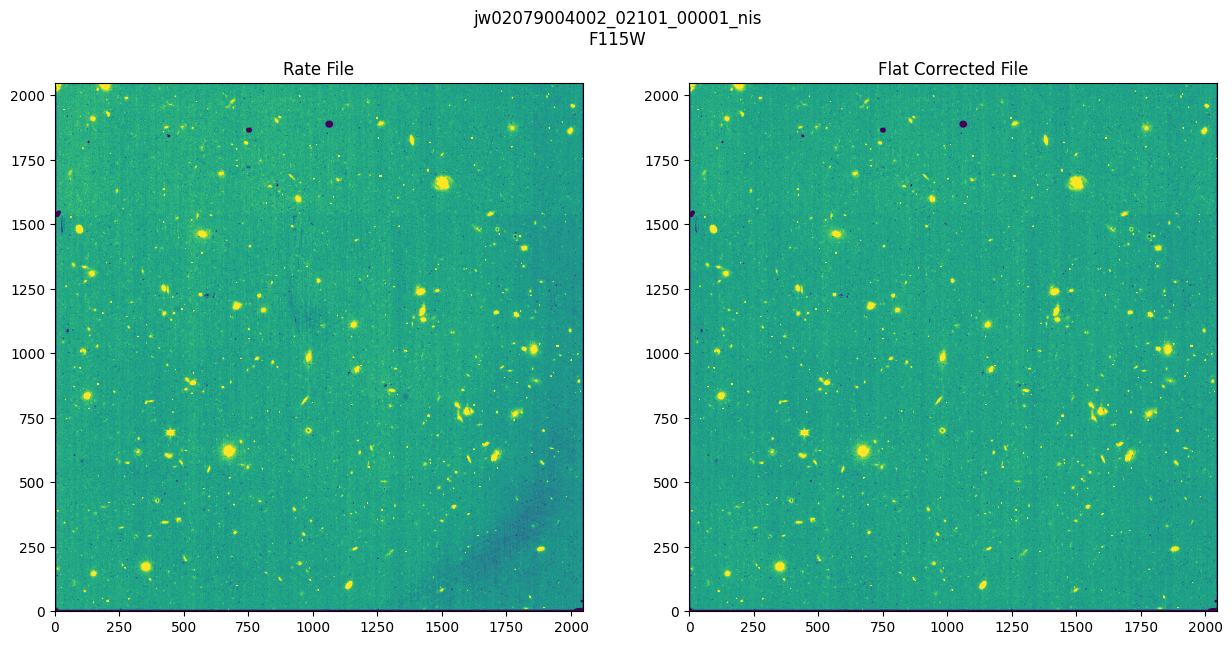

In [10]:
test_rate_file = ratefile # look at a direct image for this comparision
test_flat_file = os.path.join(data_dir_out, os.path.basename(test_rate_file).replace('rate.fits', 'flatfieldstep.fits'))

plot_files = [test_rate_file, test_flat_file]
plot_titles = ['Rate File', 'Flat Corrected File']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
fig.suptitle(f"{os.path.basename(test_rate_file).split('_rate')[0]}\n{fits.getval(test_rate_file, 'PUPIL')}", x=0.5, y=0.72)

for filename, title, ax in zip(plot_files, plot_titles, [ax1, ax2]):
    with fits.open(filename) as hdu:
        # fill in the nan values from the bad pixels with zero; otherwise a single, non-dithered image is impossible to really see
        data = hdu[1].data
        data[np.isnan(data)] = 0
        
        ax.imshow(data, vmin=0.2, vmax=1.2, origin='lower')
        ax.set_title(title)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>